<a href="https://colab.research.google.com/github/masayasato0407/pycaret_classification/blob/main/pycaret_classification_Multiplemodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#pycaretはtrain sampleとtest sampleを予め分けて準備し、4つのステップでtest sampleでの精度を解析する

①training dataとtest dataを読み込む

②狭義のtraining set (training sample全体の7割)を10分割交差検証で比較しハイパーパラメーターのチューニングする

③validation set (training sample全体の3割)も使用して、training sample全体でのモデルを作成する

④training set全体での精度の検証 (internal validation

⑤予め別に自身で準備したtest sampleで精度を検証する (external validation)
→この精度を上げるのが目的


In [ ]:
#パッケージのインストール
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd

In [ ]:
from pycaret.classification import *

#ここからは実際のデータの読み込み

In [ ]:
# ローカルファイルを直接アップロードする (train data)
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [ ]:
#train dataの読み込み
train_data = pd.read_csv('train.csv')
train_data.head()

,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event
0,1,50,1,172.2,69.5,2,1,4.0,0.5,69,48,160,29,15.3,0.2,0.0,9,0
1,2,74,1,172.4,80.2,2,1,4.0,0.8,44,28,234,75,10.7,23.8,1.4,63,1
2,3,73,1,180.8,79.3,1,1,4.0,0.5,25,24,217,16,18.9,1.9,0.3,15,0
3,4,63,1,159.8,71.4,1,2,3.1,1.4,23,17,145,49,5.3,4279.8,0.4,899,1
4,5,53,1,172.4,79.2,1,2,3.8,0.8,59,43,217,40,15.5,1.2,0.2,11,0


In [ ]:
# ローカルファイルを直接アップロードする (test data)
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
#test dataの読み込み
test_data = pd.read_csv('test.csv')
test_data.head()

,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event
0,1,52,1,171.9,55.0,1,2,3.9,0.5,17,37,238,77,12.6,0.1,0.2,8,0
1,2,67,1,168.9,71.8,1,2,3.9,1.4,62,24,268,119,11.7,10.4,0.1,7,0
2,3,77,2,165.1,69.5,1,2,4.2,1.0,68,43,178,29,14.2,3.5,0.3,7,0
3,4,73,1,171.5,60.9,1,2,3.6,0.8,40,17,257,34,4.9,0.4,0.1,10,0
4,5,56,1,172.0,54.8,1,2,3.9,0.7,41,37,229,26,12.6,0.1,0.2,7,0


#ここからステップ①、pycaretにデータの型を判別させ、training data全体ををtrainingのための狭義のtraining sampleとパラメーターを決めるためのvalidation sampleに分割する。 


In [ ]:
#train_sizeを指定しない場合は7:3に分割される
#pycaretにデータの型を判別させる (sampleIDは無視する→ignore)
exp1 = setup(train_data, target = 'event', train_size = 0.8,ignore_features = ['sampleID'])

,Description,Value
0,Session id,8612
1,Target,event
2,Target type,Binary
3,Original data shape,"(2100, 18)"
4,Transformed data shape,"(2100, 17)"
5,Transformed train set shape,"(1680, 17)"
6,Transformed test set shape,"(420, 17)"
7,Ignore features,1
8,Numeric features,16
9,Preprocess,True


#ここからステップ② 狭義のtraining set (上でtraining sample全体の8割に指定)を10分割交差検証で比較しハイパーパラメーターのチューニングする

In [ ]:
#transformed train sampleでのmodelの比較 (デフォルトは10分割交差検証)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7976,0.8574,0.4784,0.6590,0.5510,0.4255,0.4363,0.4510
xgboost,Extreme Gradient Boosting,0.7976,0.8551,0.5444,0.6387,0.5823,0.4511,0.4568,0.4280
ada,Ada Boost Classifier,0.7970,0.8498,0.5510,0.6312,0.5865,0.4532,0.4563,0.3830
lightgbm,Light Gradient Boosting Machine,0.7952,0.8565,0.5285,0.6386,0.5719,0.4402,0.4475,0.2650
gbc,Gradient Boosting Classifier,0.7893,0.8608,0.5057,0.6286,0.5569,0.4213,0.4278,0.3780
et,Extra Trees Classifier,0.7893,0.8558,0.4262,0.6508,0.5125,0.3864,0.4016,0.4200
ridge,Ridge Classifier,0.7857,0.0000,0.3265,0.6961,0.4429,0.3317,0.3687,0.0360
lda,Linear Discriminant Analysis,0.7833,0.8109,0.3581,0.6636,0.4634,0.3430,0.3693,0.0520
knn,K Neighbors Classifier,0.7827,0.7729,0.4149,0.6271,0.4978,0.3674,0.3806,0.0530
lr,Logistic Regression,0.7798,0.8043,0.3536,0.6486,0.4563,0.3333,0.3580,0.6370


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=8612, verbose=0, warm_start=False)

In [ ]:
#Logistic regressionモデルを作成
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.7516,0.2727,0.4800,0.3478,0.1951,0.2074
1,0.7321,0.7744,0.2727,0.4800,0.3478,0.1951,0.2074
2,0.8214,0.8114,0.4545,0.7692,0.5714,0.4679,0.4937
3,0.8095,0.8222,0.4091,0.7500,0.5294,0.4227,0.4532
4,0.7738,0.7881,0.2955,0.6500,0.4062,0.2900,0.3245
5,0.7738,0.7986,0.2727,0.6667,0.3871,0.2772,0.3189
6,0.8095,0.8706,0.4318,0.7308,0.5429,0.4324,0.4563
7,0.7857,0.8048,0.3864,0.6538,0.4857,0.3615,0.3814
8,0.7560,0.7757,0.3409,0.5556,0.4225,0.2789,0.2923


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#勾配ブースティング決定木 (ブースティング)モデルを作成
xgboost = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7738,0.8372,0.5227,0.5750,0.5476,0.3973,0.3981
1,0.7857,0.8589,0.4773,0.6176,0.5385,0.4019,0.4076
2,0.8274,0.8807,0.5682,0.7143,0.6329,0.5220,0.5278
3,0.7917,0.8724,0.5227,0.6216,0.5679,0.4320,0.4348
4,0.7381,0.8054,0.4545,0.5000,0.4762,0.3021,0.3027
5,0.7738,0.8510,0.3636,0.6154,0.4571,0.3260,0.3440
6,0.7798,0.8809,0.5682,0.5814,0.5747,0.4261,0.4262
7,0.8155,0.8730,0.5909,0.6667,0.6265,0.5046,0.5062
8,0.7738,0.8620,0.5000,0.5789,0.5366,0.3880,0.3899


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#ランダムフォレストモデルを作成
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7798,0.8318,0.5000,0.5946,0.5432,0.3995,0.4021
1,0.7857,0.8544,0.4318,0.6333,0.5135,0.3824,0.3939
2,0.8274,0.8809,0.5455,0.7273,0.6234,0.5144,0.5233
3,0.8095,0.8758,0.5227,0.6765,0.5897,0.4684,0.4750
4,0.7619,0.8267,0.3409,0.5769,0.4286,0.2905,0.3066
5,0.7857,0.8501,0.3636,0.6667,0.4706,0.3505,0.3758
6,0.7976,0.8796,0.5455,0.6316,0.5854,0.4525,0.4546
7,0.8274,0.8637,0.6136,0.6923,0.6506,0.5365,0.5383
8,0.7679,0.8296,0.4318,0.5758,0.4935,0.3469,0.3529


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#サポートベクターマシン (SVM)を作成
rbfsvm = create_model('rbfsvm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.6869,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7381,0.7212,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7381,0.7412,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7381,0.6926,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7381,0.6993,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7381,0.7164,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7381,0.7989,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7381,0.7650,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7381,0.7829,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#k近傍法 (knn)を作成
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.6771,0.2955,0.4815,0.3662,0.2085,0.2185
1,0.7560,0.7367,0.3182,0.5600,0.4058,0.2666,0.2835
2,0.7619,0.7889,0.3636,0.5714,0.4444,0.3023,0.3148
3,0.8155,0.7758,0.4773,0.7241,0.5753,0.4638,0.4802
4,0.7560,0.7396,0.3182,0.5600,0.4058,0.2666,0.2835
5,0.8036,0.7759,0.4091,0.7200,0.5217,0.4097,0.4356
6,0.8333,0.8361,0.5682,0.7353,0.6410,0.5348,0.5423
7,0.8214,0.8339,0.5227,0.7188,0.6053,0.4936,0.5040
8,0.7738,0.7565,0.4318,0.5938,0.5000,0.3585,0.3661


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#Naive Bayesモデルを作成
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.7409,0.2500,0.5000,0.3333,0.1923,0.2102
1,0.7679,0.7695,0.2273,0.6667,0.3390,0.2374,0.2883
2,0.7857,0.8127,0.2727,0.7500,0.4000,0.3026,0.3602
3,0.7679,0.8214,0.2500,0.6471,0.3607,0.2514,0.2939
4,0.7619,0.7856,0.2045,0.6429,0.3103,0.2105,0.2612
5,0.7619,0.7793,0.1818,0.6667,0.2857,0.1954,0.2553
6,0.8214,0.8539,0.3636,0.8889,0.5161,0.4293,0.4940
7,0.7619,0.7705,0.2955,0.5909,0.3939,0.2657,0.2905
8,0.7619,0.7667,0.2500,0.6111,0.3548,0.2391,0.2751


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#多層パーセプトロン (ニューラルネット)モデルを作成
mlp = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.7524,0.5000,0.5000,0.5000,0.3226,0.3226
1,0.8095,0.8248,0.6136,0.6429,0.6279,0.5000,0.5002
2,0.7560,0.7247,0.5455,0.5333,0.5393,0.3734,0.3734
3,0.7560,0.7473,0.5000,0.5366,0.5176,0.3546,0.3550
4,0.7976,0.8114,0.4773,0.6562,0.5526,0.4260,0.4351
5,0.7976,0.8561,0.2500,0.9167,0.3929,0.3161,0.4130
6,0.7917,0.8173,0.5909,0.6047,0.5977,0.4572,0.4572
7,0.7976,0.7736,0.3182,0.7778,0.4516,0.3533,0.4064
8,0.7083,0.7179,0.5682,0.4545,0.5051,0.3019,0.3057


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ここからハイパーパラメーターをチューニング、pycaretはランダムサーチで最適パラメーターを探索 

In [ ]:
#試行回数の指定 n_iter = 10 (時間がかかるので10にしています、50や100に設定してください)
#AUCがいいものを選ぶ場合はoptimizeを'AUC'で指定、正答率なら'Accuracy'

#Logistic regression
tuned_lr = tune_model(lr,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.7526,0.2727,0.4800,0.3478,0.1951,0.2074
1,0.7321,0.7757,0.2727,0.4800,0.3478,0.1951,0.2074
2,0.8214,0.8152,0.4545,0.7692,0.5714,0.4679,0.4937
3,0.8095,0.8222,0.4091,0.7500,0.5294,0.4227,0.4532
4,0.7738,0.7867,0.2955,0.6500,0.4062,0.2900,0.3245
5,0.7738,0.7977,0.2727,0.6667,0.3871,0.2772,0.3189
6,0.8095,0.8706,0.4318,0.7308,0.5429,0.4324,0.4563
7,0.7857,0.8037,0.3864,0.6538,0.4857,0.3615,0.3814
8,0.7440,0.7788,0.3182,0.5185,0.3944,0.2437,0.2554


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#ブースティング
tuned_xgboost = tune_model(xgboost,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.8213,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7381,0.8504,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7381,0.8798,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7381,0.8618,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7381,0.8310,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7381,0.8675,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7381,0.8809,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7381,0.8493,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7381,0.8409,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
#ランダムフォレスト
tuned_rf = tune_model(rf,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7679,0.8356,0.6136,0.5510,0.5806,0.4208,0.4220
1,0.7917,0.8528,0.6591,0.5918,0.6237,0.4802,0.4815
2,0.8095,0.8860,0.7045,0.6200,0.6596,0.5281,0.5302
3,0.8274,0.8704,0.7273,0.6531,0.6882,0.5693,0.5709
4,0.7560,0.8037,0.5682,0.5319,0.5495,0.3824,0.3827
5,0.8214,0.8750,0.5682,0.6944,0.6250,0.5093,0.5138
6,0.7917,0.8679,0.6591,0.5918,0.6237,0.4802,0.4815
7,0.7798,0.8451,0.6364,0.5714,0.6022,0.4505,0.4517
8,0.7619,0.8378,0.6591,0.5370,0.5918,0.4262,0.4307


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
#サポートベクターマシン
tuned_rbfsvm = tune_model(rbfsvm,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.6888,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7381,0.7213,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7381,0.7431,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7381,0.7007,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7381,0.6974,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7381,0.7164,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7381,0.7940,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7381,0.7650,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7381,0.7852,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#k近傍法 (knn)
tuned_knn = tune_model(knn,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.7555,0.1591,0.4667,0.2373,0.1201,0.1458
1,0.7857,0.7813,0.2500,0.7857,0.3793,0.2895,0.3592
2,0.7857,0.8226,0.2727,0.7500,0.4000,0.3026,0.3602
3,0.7857,0.8356,0.2727,0.7500,0.4000,0.3026,0.3602
4,0.7798,0.7940,0.2500,0.7333,0.3729,0.2765,0.3357
5,0.7738,0.8367,0.2045,0.7500,0.3214,0.2356,0.3079
6,0.8095,0.8845,0.3409,0.8333,0.4839,0.3913,0.4502
7,0.7857,0.8385,0.2955,0.7222,0.4194,0.3152,0.3627
8,0.7976,0.8352,0.2955,0.8125,0.4333,0.3413,0.4063


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#Naive beyesモデル
tuned_nb = tune_model(nb,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.7351,0.2273,0.5000,0.3125,0.1779,0.1991
1,0.7679,0.7842,0.2273,0.6667,0.3390,0.2374,0.2883
2,0.7857,0.8121,0.2727,0.7500,0.4000,0.3026,0.3602
3,0.7679,0.8236,0.2500,0.6471,0.3607,0.2514,0.2939
4,0.7679,0.7989,0.2273,0.6667,0.3390,0.2374,0.2883
5,0.7619,0.7846,0.1591,0.7000,0.2593,0.1797,0.2507
6,0.8214,0.8422,0.3636,0.8889,0.5161,0.4293,0.4940
7,0.7679,0.7729,0.2955,0.6190,0.4000,0.2778,0.3070
8,0.7738,0.7674,0.2045,0.7500,0.3214,0.2356,0.3079


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#多層パーセプトロン (ニューラルネット)モデル
#mlpのチューニングは時々エラーになる (n_iterを減らすなどで対応)
tuned_mlp = tune_model(mlp,  n_iter = 10, fold=10,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7381,0.7637,0.4091,0.5000,0.4500,0.2804,0.2828
1,0.7798,0.8431,0.4773,0.6000,0.5316,0.3901,0.3945
2,0.8155,0.8671,0.5682,0.6757,0.6173,0.4969,0.5001
3,0.7857,0.8479,0.4545,0.6250,0.5263,0.3923,0.4006
4,0.7679,0.8076,0.4091,0.5806,0.4800,0.3363,0.3448
5,0.7857,0.8539,0.3636,0.6667,0.4706,0.3505,0.3758
6,0.8274,0.8638,0.6136,0.6923,0.6506,0.5365,0.5383
7,0.8095,0.8416,0.5682,0.6579,0.6098,0.4847,0.4869
8,0.7560,0.8176,0.5682,0.5319,0.5495,0.3824,0.3827


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


#ここからステップ③ validation sampleも含めたtraining sample2100例全体でのモデル (final model)を固定する

In [ ]:
#ロジスティックモデルの固定
final_lr = finalize_model(tuned_lr)

In [ ]:
#ブースティングモデルの固定
final_xgboost = finalize_model(tuned_xgboost)

In [ ]:
#ランダムフォレストモデルの固定
final_rf = finalize_model(tuned_rf)

In [ ]:
#SVMモデルの固定
final_rbfsvm  = finalize_model(tuned_rbfsvm )

In [ ]:
#KNNモデルの固定
final_knn = finalize_model(tuned_knn)

In [ ]:
#Naive bayesモデルの固定
final_nb = finalize_model(tuned_nb)

In [ ]:
#mlp (ニューラルネットワーク)モデルの固定
final_mlp = finalize_model(tuned_mlp)

#ここからステップ④　training set全体での精度検証 (internal validation)

このコードは厳密にはtraining sample全体で評価を行っているのではなく、training sampleの一部である (今回ならtraining sampleの2割)　validation sampleのみでの評価を行っている

→training sample全体で行うためには、本プロセスの最後で行っているtest dataでの評価の際に用いるtest dataをtraining dataに置き換えて、test dataに行うのと同様にScoreのCSVファイルを出力する

In [ ]:
#ロジスティックモデルのinternal validation
predict_model(final_lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7833,0.8049,0.3455,0.6667,0.4551,0.3365,0.3648


In [ ]:
#ブースティングモデルのinternal validation
predict_model(final_xgboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8857,0.9392,0.6273,0.9079,0.7419,0.6717,0.6906


In [ ]:
#ランダムフォレストモデルのinternal validation
predict_model(final_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
#SVMモデルのinternal validation
predict_model(final_rbfsvm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Radial Kernel,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
#knnモデルのinternal validation
predict_model(final_knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
#Naive bayesモデルのinternal validation
predict_model(final_nb);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7810,0.7972,0.2364,0.7647,0.3611,0.2709,0.3394


In [ ]:
#MLP (ニューラルネットワーク)モデルのinternal validation
predict_model(final_mlp);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.8000,0.8619,0.4727,0.6667,0.5532,0.4291,0.4396


#ここからステップ⑤　予め別に自身で準備したtest sampleで精度を検証する (external validation)→この精度を上げるのが目的

In [ ]:
#ロジスティックモデルの評価
prediction_lr = predict_model(final_lr, data = test_data)
prediction_lr

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7911,0.8371,0.4050,0.6901,0.5104,0.3889,0.4112


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,0.9122
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,0,0.5925
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.7465
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.6189
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,0.8961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.8523
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.8549
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,0.8420
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.9646


In [ ]:
#ブースティングモデルの評価
prediction_xg = predict_model(final_xgboost, data = test_data)
prediction_xg

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8178,0.8932,0.5496,0.7074,0.6186,0.5014,0.5083


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,0.9811
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,1,0.5021
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.8495
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.6260
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,0.9664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.8185
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.8063
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,0.9786
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.9419


In [ ]:
#ランダムフォレストモデルの評価
prediction_rf = predict_model(final_rf, data = test_data)
prediction_rf

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8089,0.8778,0.5331,0.6862,0.6000,0.4770,0.4836


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,1.00
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,1,0.65
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.66
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.53
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.78
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.76
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,1.00
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.79


In [ ]:
#SVMモデルの評価
prediction_svm = predict_model(final_rbfsvm, data = test_data)
prediction_svm

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Radial Kernel,0.7311,0.7624,0.0041,0.5000,0.0082,0.0038,0.0246


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,0.9999
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,0,0.6961
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.6961
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.7208
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,0.9902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.6964
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.6961
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,0.8178
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.6961


In [ ]:
#knnモデルの評価
prediction_knn = predict_model(final_knn, data = test_data)
prediction_knn

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.7789,0.8422,0.2521,0.7722,0.3801,0.2855,0.3521


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,1.0000
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,0,0.6433
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.8080
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.6042
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.8805
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.7449
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,1.0000
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.9579


In [ ]:
#Naive bayesモデルの評価
prediction_nb = predict_model(final_nb, data = test_data)
prediction_nb

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7733,0.8137,0.2521,0.7262,0.3742,0.2736,0.3309


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,0.9998
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,0,0.9924
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.9988
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.9976
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,0.9997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.9994
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,0,0.9991
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,0.9995
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,1.0000


In [ ]:
#MLPモデルの評価
prediction_mlp = predict_model(mlp, data = test_data)
prediction_mlp

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.7878,0.8421,0.3802,0.6917,0.4907,0.3706,0.3971


,sampleID,con1,dis1,con2,con3,dis2,dis3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,event,prediction_label,prediction_score
0,1,52,1,171.899994,55.000000,1,2,3.9,0.5,17,37,238,77,12.6,0.100000,0.2,8,0,0,0.9836
1,2,67,1,168.899994,71.800003,1,2,3.9,1.4,62,24,268,119,11.7,10.400000,0.1,7,0,1,0.5314
2,3,77,2,165.100006,69.500000,1,2,4.2,1.0,68,43,178,29,14.2,3.500000,0.3,7,0,0,0.9089
3,4,73,1,171.500000,60.900002,1,2,3.6,0.8,40,17,257,34,4.9,0.400000,0.1,10,0,0,0.8366
4,5,56,1,172.000000,54.799999,1,2,3.9,0.7,41,37,229,26,12.6,0.100000,0.2,7,0,0,0.9735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,71,1,165.100006,70.500000,1,2,4.3,0.9,28,24,178,21,11.8,3.800000,0.0,8,0,0,0.9135
896,897,56,2,156.600006,71.199997,1,2,4.3,0.5,23,37,162,52,11.2,34.700001,2.6,13,1,1,0.5337
897,898,69,1,165.699997,54.000000,1,2,3.9,0.8,17,63,324,77,12.5,0.200000,0.2,8,0,0,0.9836
898,899,61,2,159.000000,47.900002,1,2,4.4,0.9,18,23,362,48,19.9,2.500000,0.1,10,0,0,0.9910


#既存のスコアリングシステムなどとの比較をしやすくするため、統計ソフトでの解析用に機械学習が出したスコアと正解ラベルをcsvファイルで出力する。

注意点: AUCを出すためにはprediction_label=0のものは、prediction=1の確率に変換をする

In [ ]:
#ロジスティックモデルの予測出力 (左のフォルダにcsvが出ているので、ファイル右の点3つからダウンロード)
prediction_lr.to_csv('prediction_lr.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#ブースティングの予測出力
prediction_xg.to_csv('prediction_xg.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#ランダムフォレストの予測出力
prediction_rf.to_csv('prediction_rf.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#SVMの予測出力
prediction_svm.to_csv('prediction_svm.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#knnの予測出力
prediction_knn.to_csv('prediction_knn.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#Naive bayesの予測出力
prediction_nb.to_csv('prediction_nb.csv', columns=['event','prediction_label','prediction_score'])

In [ ]:
#MLP (ニューラルネットワーク)の予測出力
prediction_mlp.to_csv('prediction_mlp.csv', columns=['event','prediction_label','prediction_score'])

#ハイパーパラメーターや変数の重要度等を一斉に出力する(catboostなどでは出力されない)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

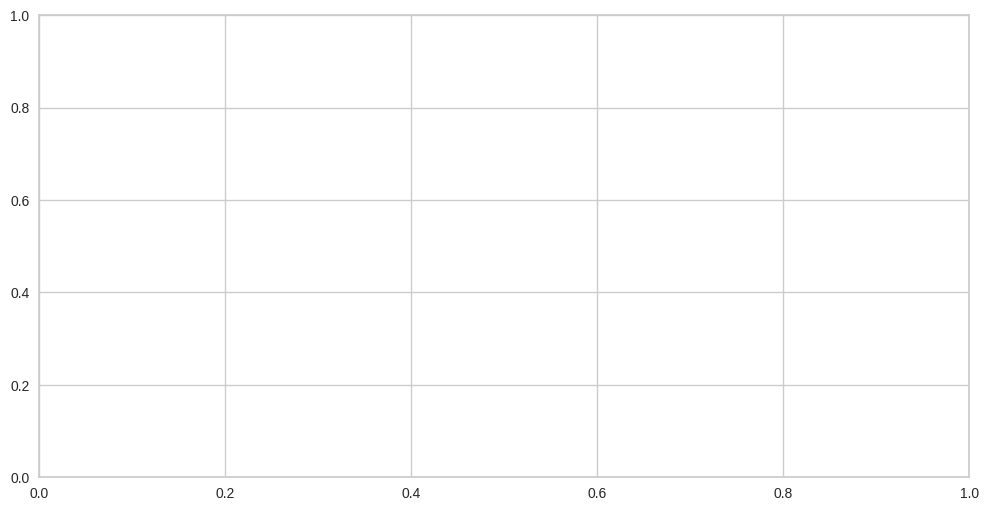

In [ ]:
evaluate_model(final_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

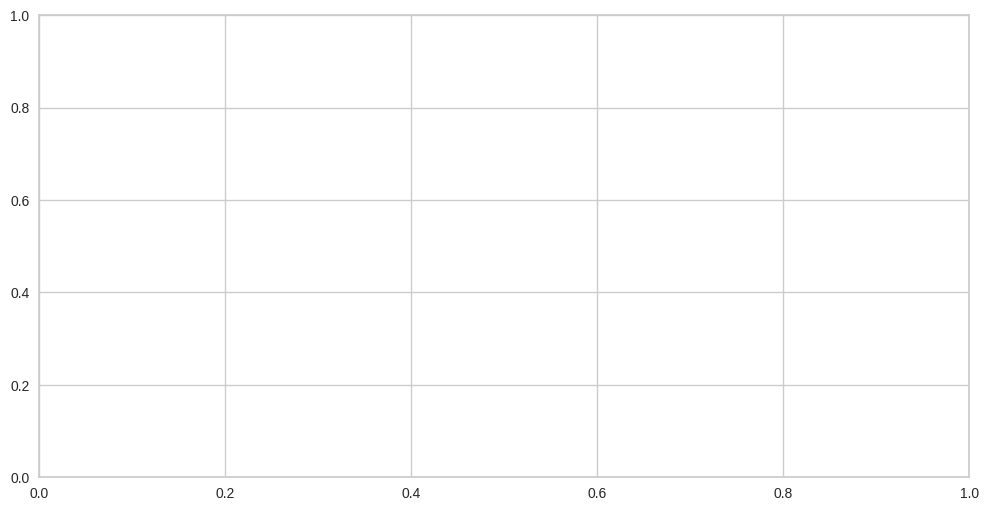

In [ ]:
evaluate_model (final_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

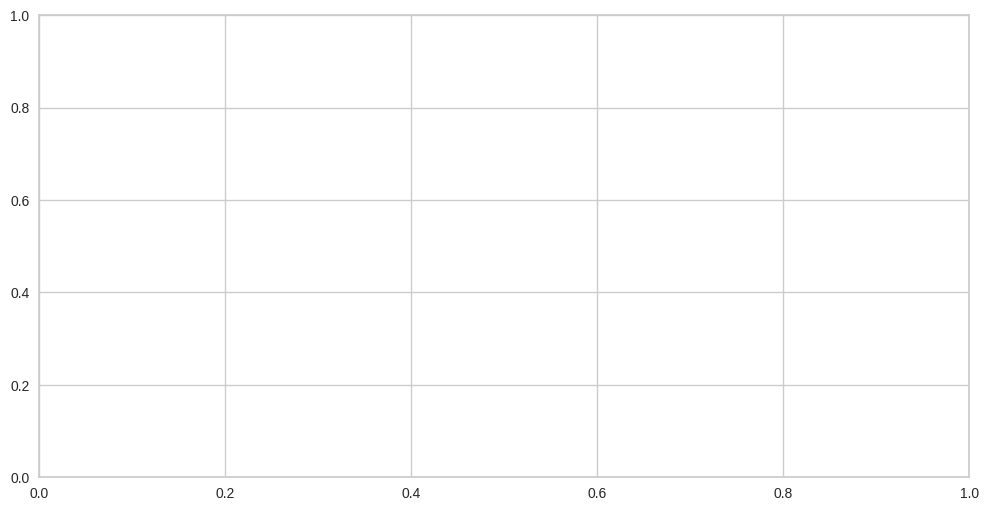

In [ ]:
evaluate_model (final_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

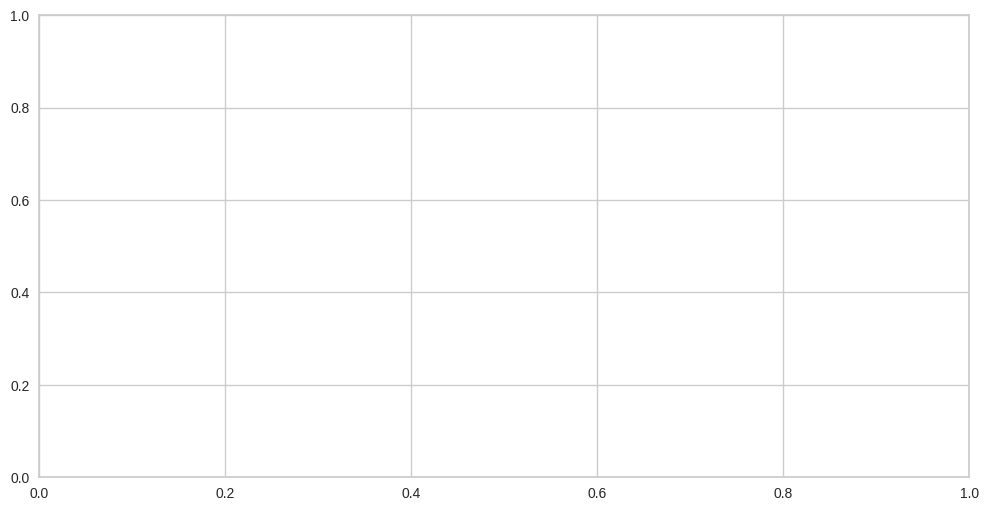

In [ ]:
evaluate_model (final_rbfsvm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

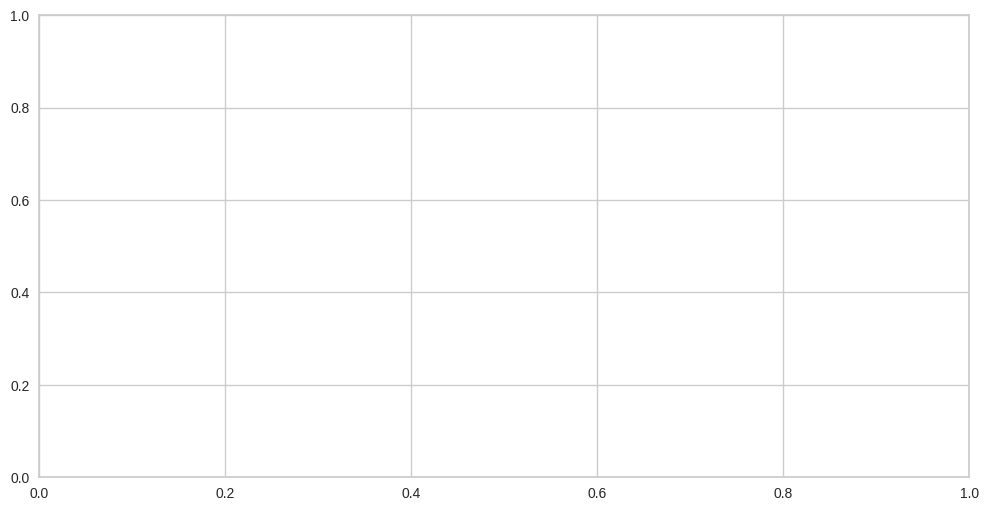

In [ ]:
evaluate_model (final_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

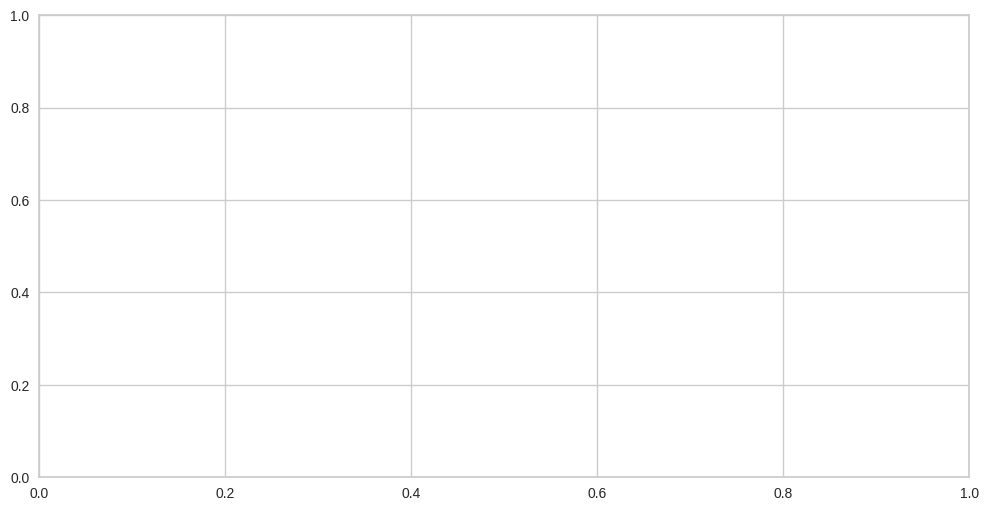

In [ ]:
evaluate_model (final_nb)